In [10]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import random
from scipy import ndimage
import time
import datetime

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from keras.utils import Sequence

In [11]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("maximnaddaf/ct-multi-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ct-multi-data


In [12]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])


test = "/kaggle/input/ct-multi-data/Processed_CT_Scans/test/CT-0"
test_2  = "/kaggle/input/ct-multi-data/Processed_CT_Scans/test/CT-23"

train = "/kaggle/input/ct-multi-data/Processed_CT_Scans/train/CT-0"
train_2  = "/kaggle/input/ct-multi-data/Processed_CT_Scans/train/CT-23"

print(f"Number of directories in test (CT-0, CT-23): {count_directories(test)}, {count_directories(test_2)}")
print(f"Number of directories in train (CT-0, CT-23): {count_directories(train)}, {count_directories(train_2)}")

Number of directories in test (CT-0, CT-23): 172, 172
Number of directories in train (CT-0, CT-23): 860, 860


In [16]:
def load_nii(file_path):
    return nib.load(file_path).get_fdata()

class MultiModalDataset(Sequence):
    def __init__(self, patient_dirs, labels, batch_size, fold, shuffle=True):
        self.patient_dirs = patient_dirs
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.fold = fold
        self.indices = np.arange(len(self.patient_dirs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.patient_dirs) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patient_dirs = [self.patient_dirs[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        # Load modalities
        X = self.__load_modalities(batch_patient_dirs)
        y = np.array(batch_labels)

        X = tuple(tf.convert_to_tensor(x, dtype=tf.float32) for x in X)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_modalities(self, patient_dirs):
        modalities = {'split_1': [], 'split_2': []}

        for patient_dir in patient_dirs:
            patient_name = os.path.basename(patient_dir)

            split_1_path = os.path.join(patient_dir, 'split_part_1.nii')
            split_2_path = os.path.join(patient_dir, 'split_part_2.nii')

            # Load each modality
            split_1 = load_nii(split_1_path)
            split_2 = load_nii(split_2_path)

            modalities['split_1'].append(split_1)
            modalities['split_2'].append(split_2)


        # Stack the modalities for each patient along the first axis (batch axis)
        X = [
            np.array(modalities['split_1']),
            np.array(modalities['split_2']),
        ]

        return X


def load_data_from_folder(base_dir):
    patient_dirs = []
    labels = []

    for class_name in ["CT-0", "CT-23"]:  # Only two known classes
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        label = 0 if class_name == "CT-0" else 1

        for study_name in os.listdir(class_path):
            study_path = os.path.join(class_path, study_name)
            if os.path.isdir(study_path):
                patient_dirs.append(study_path)
                labels.append(label)

    return np.array(patient_dirs), np.array(labels)

# Load and shuffle train data
train_dirs, train_labels = load_data_from_folder("/kaggle/input/ct-multi-data/Processed_CT_Scans/train")
train_indices = np.arange(len(train_dirs))
np.random.shuffle(train_indices)
train_dirs = train_dirs[train_indices]
train_labels = train_labels[train_indices]

# Load and shuffle test data
test_dirs, test_labels = load_data_from_folder("/kaggle/input/ct-multi-data/Processed_CT_Scans/test")
test_indices = np.arange(len(test_dirs))
np.random.shuffle(test_indices)
test_dirs = test_dirs[test_indices]
test_labels = test_labels[test_indices]

# Create your dataset objects
train_dataset = MultiModalDataset(train_dirs, train_labels, batch_size=16, fold="train", shuffle=True)
test_dataset = MultiModalDataset(test_dirs, test_labels, batch_size=8, fold="test", shuffle=True)

X, y = train_dataset[0]
X_2,y_2 = test_dataset[0]

for modality, data in zip(['split_1', 'split_2'], X):
    print(f"training set Shape of {modality} modality: {data.shape}")

print("\n")

for modality, data in zip(['split_1', 'split_2'], X_2):
    print(f"testing set Shape of {modality} modality: {data.shape}")

print("\n")

print(f"training labels: {y}")
print(f"testing labels:  {y_2}")

training set Shape of split_1 modality: (16, 224, 224, 25)
training set Shape of split_2 modality: (16, 224, 224, 25)


testing set Shape of split_1 modality: (8, 224, 224, 25)
testing set Shape of split_2 modality: (8, 224, 224, 25)


training labels: [1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1]
testing labels:  [1 0 0 0 0 0 1 0]


Number of scans: 2
Dimension of CT scan: (224, 224, 25)
label= 1


Number of scans: 2
Dimension of CT scan: (224, 224, 25)
label= 1


Number of scans: 2
Dimension of CT scan: (224, 224, 25)
label= 1


Number of scans: 2
Dimension of CT scan: (224, 224, 25)
label= 0




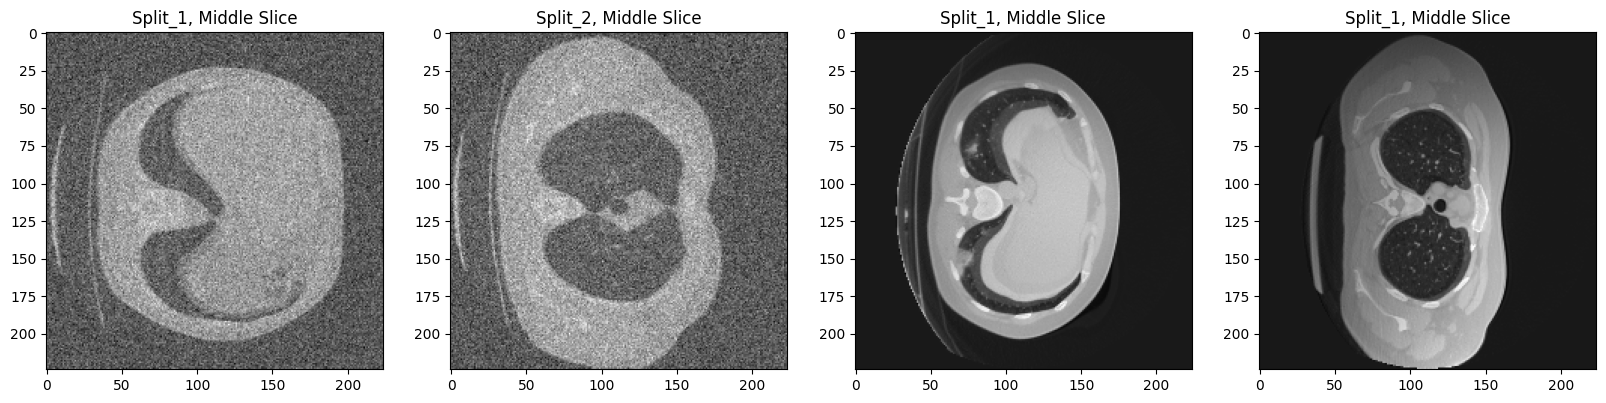

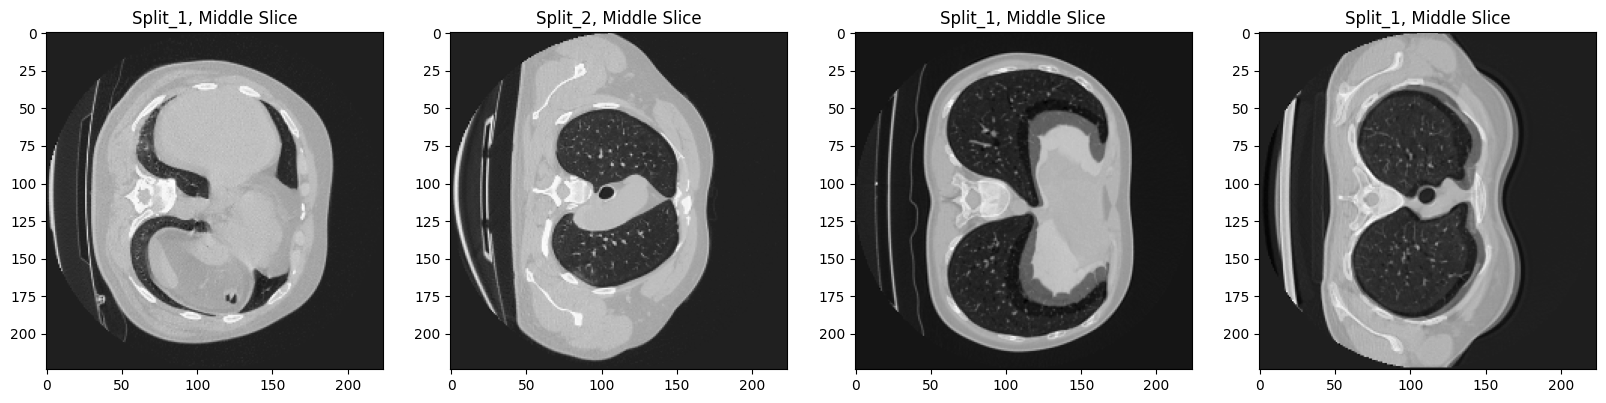

In [19]:
def plot_scans_from_dataset(dataset):

    fig = plt.figure(figsize=(20,8))

    for i in range(2):
        scans, label = dataset[i]
        print("Number of scans:", len(scans))
        print("Dimension of CT scan:", scans[0][0].shape)
        print("label=",label[i])
        print("\n")

        ax1 = plt.subplot(1,4,1)
        ax1.imshow(scans[0][0][:,:, scans[0][0].shape[2] // 2], cmap="gray")
        ax1.set_title("Split_1, Middle Slice")
        
        ax2 = plt.subplot(1,4,2)
        ax2.imshow(scans[1][0][:,:, scans[1][0].shape[2] // 2], cmap="gray")
        ax2.set_title("Split_2, Middle Slice")
        
        ax3 = plt.subplot(1,4,3)
        ax3.imshow(scans[0][1][:,:, scans[0][0].shape[2] // 2], cmap="gray")
        ax3.set_title("Split_1, Middle Slice")
        
        ax4 = plt.subplot(1,4,4)
        ax4.imshow(scans[1][1][:,:, scans[1][0].shape[2] // 2], cmap="gray")
        ax4.set_title("Split_1, Middle Slice")

plot_scans_from_dataset(train_dataset)
plot_scans_from_dataset(test_dataset)

In [20]:
def get_model(inputs):
    """Build a 3D convolutional neural network model."""
     
    x = Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    return x

In [21]:
tf.random.set_seed(42)

split_1_input = Input(shape=(224, 224, 25, 1))
split_1_model = get_model(split_1_input)

split_2_input = Input(shape=(224, 224, 25, 1))
split_2_model = get_model(split_2_input)


# Concat models and add final block
x = concatenate([split_1_model, split_2_model])

x = GlobalAveragePooling3D()(x)
x = Dense(units=700, activation="relu")(x)
x = Dropout(0.3)(x)

output_layer = Dense(units=1, activation="sigmoid")(x)

# Final model
cnn_model = Model(inputs=[split_1_input, split_2_input], outputs=[output_layer], name="multi3dcnn")


initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=False
)

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 20, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model_save = ModelCheckpoint(f'3d_image_classification.keras',
                             save_best_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)

# Compile final model
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  metrics=["accuracy", "AUC"])

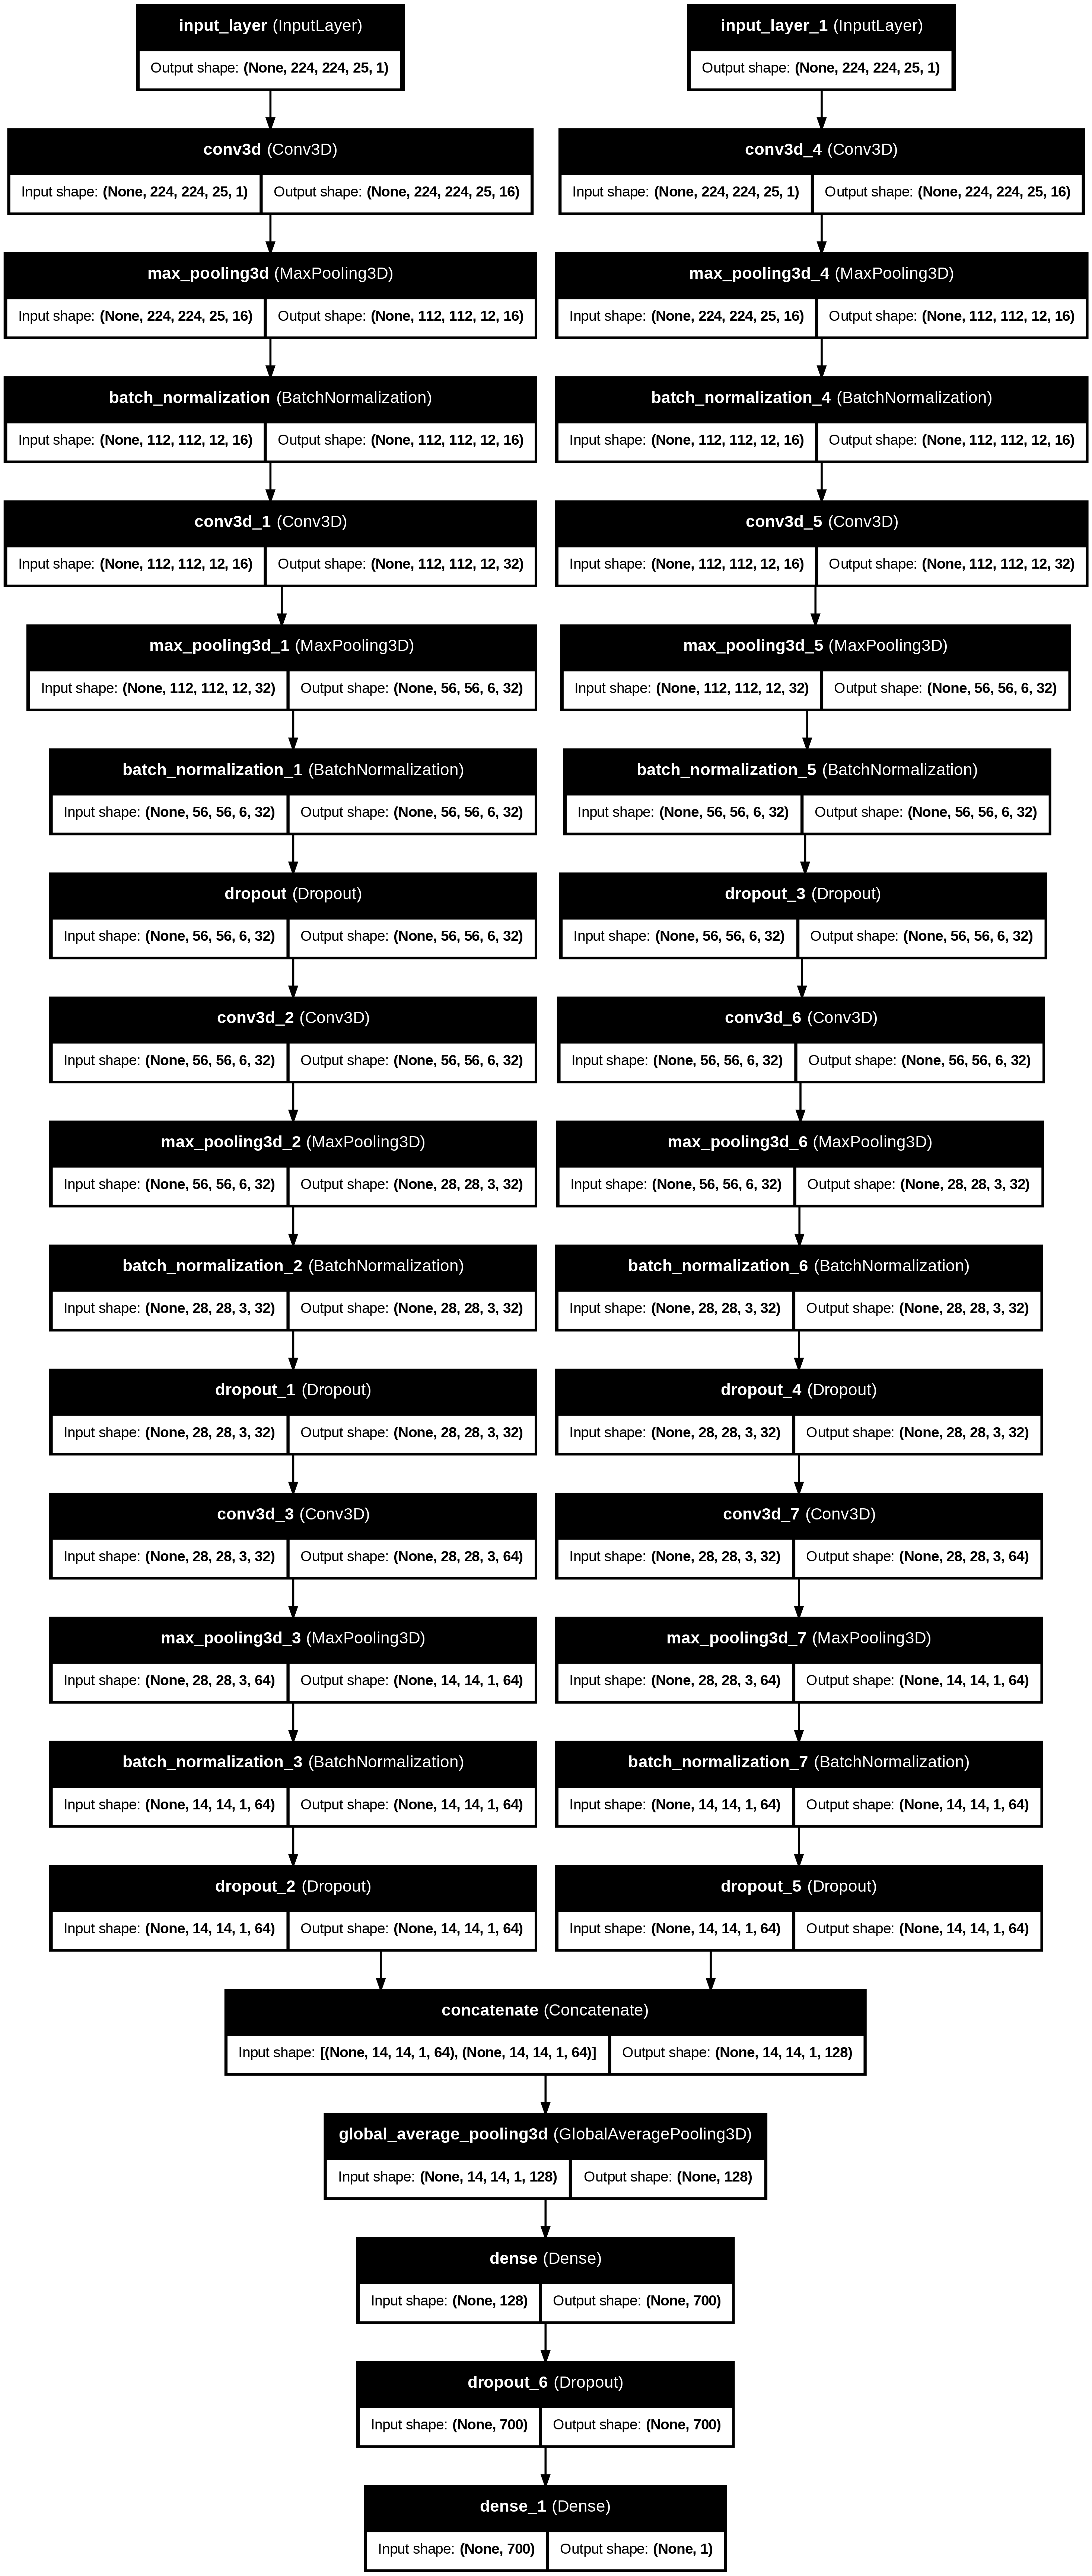

In [22]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

In [23]:
cnn_model.summary()

Model: "multi3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 25,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 224, 224, 25,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 224, 224, 25,   │            448 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 224, 224, 25,   │            448 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 112, 112, 12,   │              0 │ conv3d[0][0]           │
│ (MaxPooling3D)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 112, 112, 12,   │              0 │ conv3d_4[0][0]         │
│ (MaxPooling3D)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 12,   │             64 │ max_pooling3d[0][0]    │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 12,   │             64 │ max_pooling3d_4[0][0]  │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 112, 112, 12,   │         13,856 │ batch_normalization[0… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 112, 112, 12,   │         13,856 │ batch_normalization_4… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 56, 56, 6, 32)  │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 56, 56, 6, 32)  │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 6, 32)  │            128 │ max_pooling3d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 286,841 (1.09 MB)

 Trainable params: 286,265 (1.09 MB)

 Non-trainable params: 576 (2.25 KB)

In [24]:
from tensorflow.keras.callbacks import Callback

class GPUUsageCallback(Callback):
    def __init__(self):
        super().__init__()
        self.peak_gpu_memory_usage = []  # To store memory usage for each epoch

    def on_epoch_end(self, epoch, logs=None):
        # Get the current GPU memory usage
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            device_name = f'GPU:0'
            memory_info = tf.config.experimental.get_memory_info(device_name)
            memory_usage = memory_info['current'] / 1024 / 1024  # Convert bytes to MB

            # Append to the list
            self.peak_gpu_memory_usage.append(memory_usage)

            # Print epoch number and memory usage
            print(f"Epoch {epoch + 1}: GPU Memory Usage = {memory_usage:.2f} MB")

# Assuming you have your model and data
gpu_usage = GPUUsageCallback()

In [25]:
start_time = time.time()
history = cnn_model.fit(train_dataset, validation_data=test_dataset, epochs=60, callbacks=[model_save, early_stop, gpu_usage])
end_time = time.time()

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744248171.486898     100 service.cc:148] XLA service 0x7a17900029d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744248171.493467     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744248171.493502     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744248173.206416     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744248176.950057     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.5516 - accuracy: 0.5339 - loss: 0.6969

E0000 00:00:1744248531.503367      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744248531.673865      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.75629, saving model to 3d_image_classification.keras
Epoch 1: GPU Memory Usage = 335.95 MB
107/107 ━━━━━━━━━━━━━━━━━━━━ 465s 4s/step - AUC: 0.5521 - accuracy: 0.5342 - loss: 0.6967 - val_AUC: 0.6407 - val_accuracy: 0.5000 - val_loss: 0.7563
Epoch 2/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6450 - accuracy: 0.5956 - loss: 0.6607
Epoch 2: val_loss did not improve from 0.75629
Epoch 2: GPU Memory Usage = 336.02 MB
107/107 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - AUC: 0.6451 - accuracy: 0.5957 - loss: 0.6607 - val_AUC: 0.6797 - val_accuracy: 0.5000 - val_loss: 0.8513
Epoch 3/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6855 - accuracy: 0.6525 - loss: 0.6381
Epoch 3: val_loss did not improve from 0.75629
Epoch 3: GPU Memory Usage = 336.10 MB
107/107 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - AUC: 0.6856 - accuracy: 0.6524 - loss: 0.6381 - val_AUC: 0.7032 - val_accuracy: 0.5000 - val_loss: 0.9702
Epoch 4/60
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/ste

In [26]:
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 9943.46 seconds


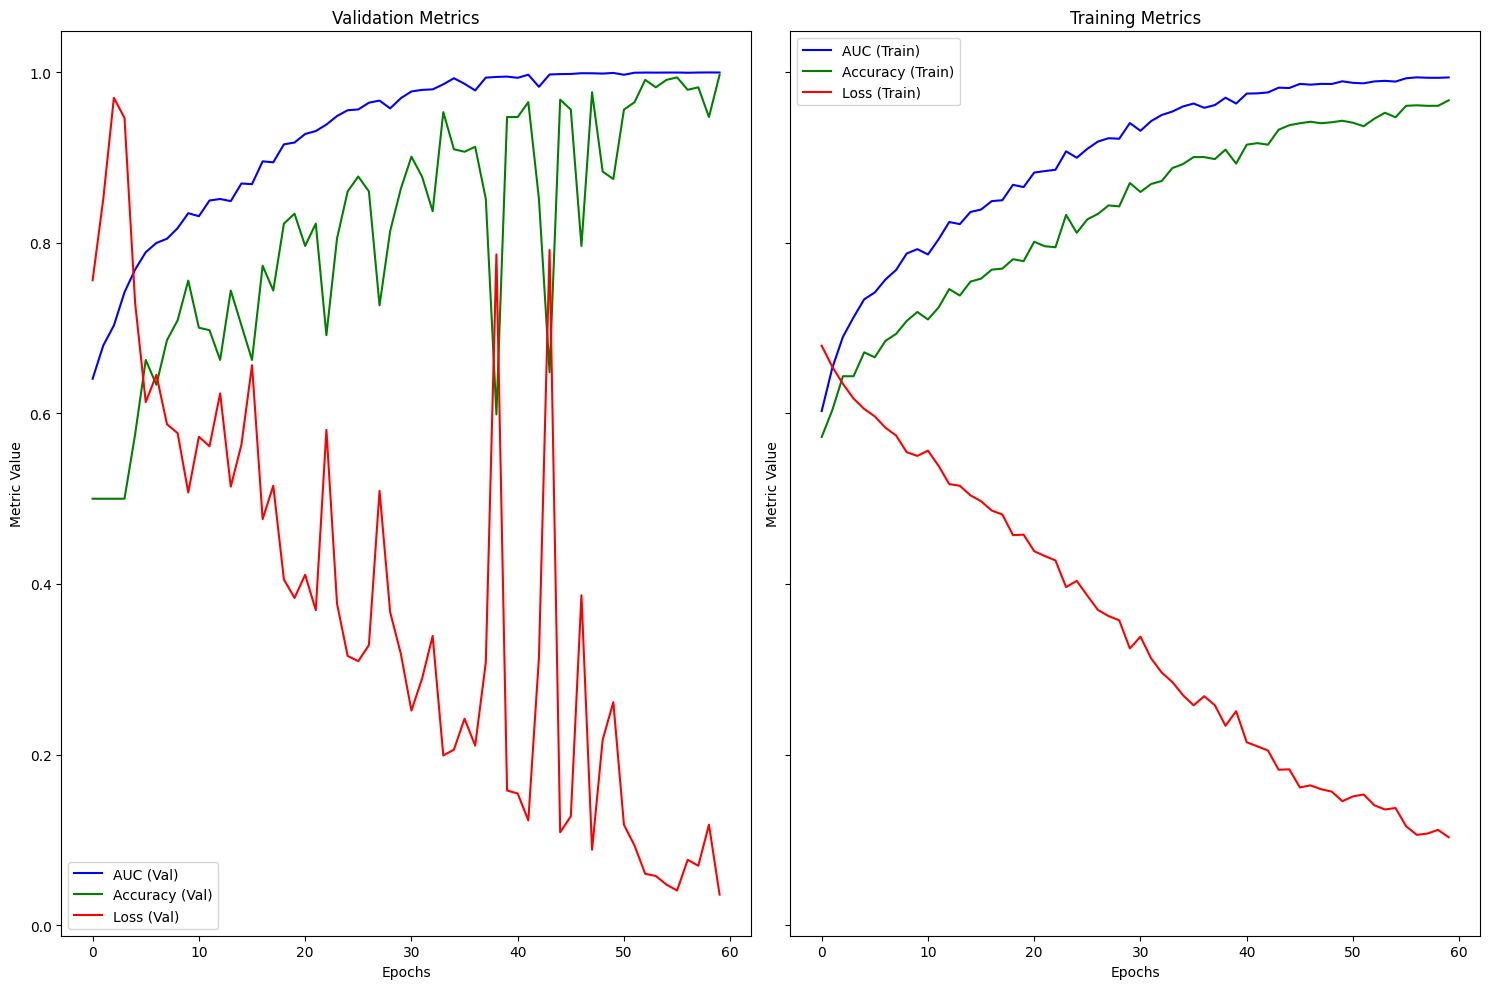

In [27]:
import pandas as pd

history_df = pd.DataFrame(history.history)

# Set up the figure for the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

# Plot validation metrics (val_AUC, val_accuracy, val_loss)
axes[0].plot(history_df['val_AUC'], label='AUC (Val)', color='blue')
axes[0].plot(history_df['val_accuracy'], label='Accuracy (Val)', color='green')
axes[0].plot(history_df['val_loss'], label='Loss (Val)', color='red')

axes[0].set_title('Validation Metrics')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Metric Value')
axes[0].legend()

# Plot training metrics (AUC, accuracy, loss)
axes[1].plot(history_df['AUC'], label='AUC (Train)', color='blue')
axes[1].plot(history_df['accuracy'], label='Accuracy (Train)', color='green')
axes[1].plot(history_df['loss'], label='Loss (Train)', color='red')

axes[1].set_title('Training Metrics')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Metric Value')
axes[1].legend()

plt.tight_layout()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 569ms/step - AUC: 0.9999 - accuracy: 0.9982 - loss: 0.0342


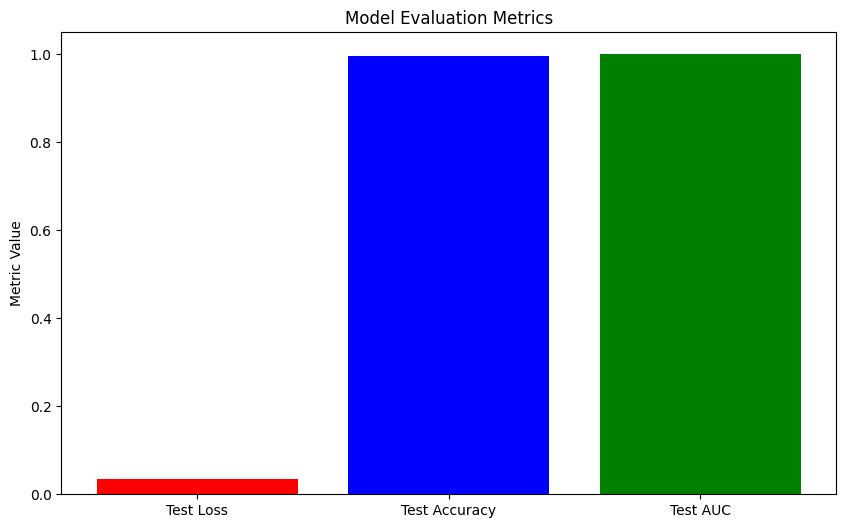

In [30]:
test_loss, test_accuracy, test_auc = cnn_model.evaluate(test_dataset)

# Store evaluation metrics for later plotting
eval_metrics = {
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Test AUC': test_auc
}

# Create a bar plot to visualize evaluation metrics
plt.figure(figsize=(10, 6))
plt.bar(eval_metrics.keys(), eval_metrics.values(), color=['red', 'blue', 'green'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Metric Value')
plt.show()

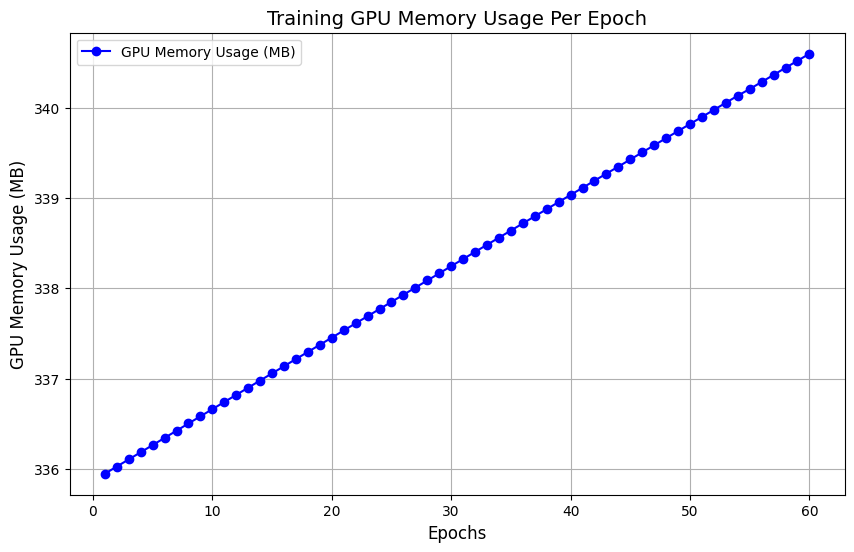

In [29]:
gpu_memory_usage = gpu_usage.peak_gpu_memory_usage  # List of GPU memory usage for each epoch
epochs = list(range(1, len(gpu_memory_usage) + 1))

# Plotting the GPU memory usage over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, gpu_memory_usage, marker='o', color='b', label='GPU Memory Usage (MB)')

# Add labels and title
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('GPU Memory Usage (MB)', fontsize=12)
plt.title('Training GPU Memory Usage Per Epoch', fontsize=14)

# Display the grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()